In [55]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

# Load the raw point cloud
MM_TO_M = 1 / 1000.0
pcd_path = "PointCloud/PointCloud_box_a2.pcd" # only a3 has problem due to sparse top
pcd = o3d.io.read_point_cloud(pcd_path)

# Convert units (assumes points are in mm)
points = np.asarray(pcd.points, dtype=np.float64) * MM_TO_M
pcd.points = o3d.utility.Vector3dVector(points)

In [ ]:
# Visualize raw point cloud
o3d.visualization.draw_geometries([pcd], window_name="Raw Point Cloud")

### Fixed tiled Camera - maybe required for bounding box later as well as z-axis filter

tilt adjustment is automatic, but must follow these conditions: 

- The table must be the largest flat surface in the scene.

- The point cloud must include enough of the table — not just the box.

- Camera must not be too far tilted (e.g., looking from the side).

If those conditions hold (which they usually do in top-down LIDAR setups), then RANSAC will find the table plane accurately, and the leveling will succeed.

https://www.open3d.org/docs/latest/tutorial/Basic/pointcloud.html

In [23]:
# Adjust point cloud to level -> adjust tilt with RANSAC
# Rotate the point cloud so the dominant plane (which is table) becomes horizontal
def level_cloud(pcd, distance_thresh=0.002, num_iters=1000): # set RANSAC distance_thresh and num_iters
    # Use RANSAC (random sample consensus (RSC)) to segment the dominant plane: ax + by + cz + d = 0, 3 main steps in RANSAC: 
    # 1. Randomly sample 3 points from point cloud
    # 2. Estimate a plane from the 3 points: ax + by + cz + d = 0
    # 3. Retain points that are close to the estimated plane
    (a, b, c, d), inliers = pcd.segment_plane(distance_thresh,
                                              ransac_n=3,
                                              num_iterations=num_iters)
    
    print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")
    
    # Get and normalize the normal vector of the plane
    n = np.array([a, b, c])
    n /= np.linalg.norm(n)

    # Target vector (we want to rotate n to align with Z-axis)
    z = np.array([0, 0, 1])

    # Compute rotation axis (cross product between n and Z)
    v = np.cross(n, z)
    s = np.linalg.norm(v)

    # Compute rotation matrix
    if s < 1e-6:
        # If n is already aligned with Z, no rotation needed
        R = np.eye(3)
    else:
        # # Compute rotation matrix using Rodrigues rotation formula
        c_dot = np.dot(n, z)
        vx = np.array([[0, -v[2], v[1]],
                       [v[2], 0, -v[0]],
                       [-v[1], v[0], 0]])
        R = np.eye(3) + vx + vx @ vx * ((1 - c_dot) / (s ** 2))

    centroid = np.asarray(pcd.points)[inliers[0]]

    # Translate to origin -> rotate -> translate back
    pcd = pcd.translate(-centroid, relative=False)
    pcd = pcd.rotate(R, center=(0, 0, 0))
    pcd = pcd.translate(centroid, relative=False)
    return pcd

pcd = level_cloud(pcd)
o3d.visualization.draw_geometries([pcd], window_name="Leveled Point Cloud")


Plane equation: -0.01x + -0.13y + 0.99z + -0.64 = 0


In [101]:
# Save PCD
pcd.points = o3d.utility.Vector3dVector(
    np.asarray(pcd.points) * 1000.0) # convert back m → mm

o3d.io.write_point_cloud("tilted_mm_ascii.pcd",
                         pcd,
                         write_ascii=True)

True

In [56]:
# variant which filters and then fix tilt
def level_and_filter(pcd: o3d.geometry.PointCloud,
                     distance_thresh=0.002,
                     num_iters=1000,
                     z_margin=0.005) -> o3d.geometry.PointCloud:
    """
    1) RANSAC‐fit the dominant plane (table) and rotate it horizontal.
    2) Remove all points whose Z is below (table_z + z_margin).
    """
    # --- 1) Fit table and build leveling transform ---
    (a, b, c, d), inliers = pcd.segment_plane(distance_thresh,
                                              ransac_n=3,
                                              num_iterations=num_iters)
    # pick one table inlier as pivot
    centroid = np.asarray(pcd.points)[inliers[0]]
    # normal → unit
    n = np.array([a, b, c])
    n /= np.linalg.norm(n)
    # build Rodrigues rotation to send n → [0,0,1]
    z = np.array([0, 0, 1.0])
    v = np.cross(n, z)
    s = np.linalg.norm(v)
    if s < 1e-6:
        R = np.eye(3)
    else:
        c_dot = np.dot(n, z)
        vx = np.array([[   0, -v[2],  v[1]],
                       [ v[2],    0, -v[0]],
                       [-v[1],  v[0],   0]])
        R = np.eye(3) + vx + vx @ vx * ((1 - c_dot) / (s**2))

    # apply centering → rotation → decentering
    pcd = pcd.translate(-centroid, relative=False)
    pcd = pcd.rotate(R, center=(0, 0, 0))
    pcd = pcd.translate(centroid, relative=False)

    # --- 2) Height filter in leveled frame ---
    # after leveling, the table plane goes through z = centroid[2]
    table_z = centroid[2]
    print(table_z)
    pts = np.asarray(pcd.points)
    keep = pts[:, 2] <= (table_z + z_margin)

    return pcd.select_by_index(np.where(keep)[0])

pcd = level_and_filter(pcd,
                        distance_thresh=0.002, # how tightly the plane fitting should hug the data, 2mm
                        num_iters=1000,
                        z_margin=0.025) # how far above the detected table plane points are still considered part of the "table" and kept in the point cloud, 25mm default seems fine

o3d.visualization.draw_geometries([pcd],
                                  window_name="Leveled + Z‐filtered")


-0.6143310544411746


### Remove noise (optional step) - Not requried to work

Might actually be worse to have this, since it remove some points on box

In [102]:
pcd, _ = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
o3d.visualization.draw_geometries([pcd], window_name="After Noise Removal")

### Fit and Extract the Table Plane

In [57]:
# Fit a plane to the point cloud using RANSAC, similar to level_cloud using RANSAC
def plane_fit(cloud, thresh=0.005, n_iter=1000):
    # Fit with RANSAC
    (a, b, c, d), inliers = cloud.segment_plane(thresh, ransac_n=3, num_iterations=n_iter)
     # Normalize the normal vector and d value
    n = np.array([a, b, c])
    norm = np.linalg.norm(n)
    n /= norm
    d /= norm
    return n, d, inliers

n_tab, d_tab, table_inliers = plane_fit(pcd) # Finds the table plane, extract normal vecotr (n_tab) and offset (d_tab)
table_pc = pcd.select_by_index(table_inliers) # table object (dominant flat plane)
obj_pc = pcd.select_by_index(table_inliers, invert=True) # all other object, found by using invert=True

# Visualize
table_pc.paint_uniform_color([1, 0, 0])
obj_pc.paint_uniform_color([0.5, 0.5, 0.5])
o3d.visualization.draw_geometries([table_pc, obj_pc], window_name="Table (Red) and Object (Gray)")


In [17]:
o3d.visualization.draw_geometries([obj_pc]) # visualize just one item

### Cluster Remaining Points to Identify the Box

Identifying and isolating the box (or object) from the set of non-table points using clustering
- eps = 0.02: max distance (in meter) between neighboring points in a cluster (2 cm)
- min_points = 20: minimum number of points to form a dense cluster

Before this, let's apply a Z-threshold filter based on the detected table plane height, before clustering.

In [7]:
# cluster non-table points that are above the table surface, z-filter step
# Convert to NumPy array
obj_points = np.asarray(obj_pc.points)

# Compute Z of table at origin (assuming table normal is upward)
# Plane eq: ax + by + cz + d = 0 → at (0, 0, z): cz + d = 0 → z = -d/c
table_z = -d_tab / n_tab[2]  # Estimate table height at Z-axis intercept

# Add small offset to avoid points just slightly below the surface
z_margin = 0.005  # 5 mm
mask = obj_points[:, 2] <= (table_z + z_margin)

# Filter only points above the table
obj_above_table = obj_pc.select_by_index(np.where(mask)[0])

o3d.visualization.draw_geometries([obj_above_table]) # visualize just one item

In [58]:
# use "obj_above_table" if using code above for filter z-axis, if filter in level_cloud section use "obj_pc"
labels = np.array(obj_pc.cluster_dbscan(eps=0.02, min_points=20)) # DBSCAN clustering
largest = np.bincount(labels[labels >= 0]).argmax() # Finds the most populated cluster (assumed to be the box)
box_pc = obj_pc.select_by_index(np.where(labels == largest)[0]) # Selects only the points that belong to the largest cluster.

# Visualize
box_pc.paint_uniform_color([0.2, 0.8, 1.0])
o3d.visualization.draw_geometries([box_pc], window_name="Detected Box Cluster")

### Cluster ranking and visualization of "obj_pc"

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Run DBSCAN
labels = np.array(obj_pc.cluster_dbscan(eps=0.02, min_points=20))

# 2) Compute counts for each label (ignore noise=-1)
unique, counts = np.unique(labels, return_counts=True)
mask = unique >= 0
clusters = unique[mask]
sizes    = counts[mask]

# 3) Sort clusters by descending size
order = np.argsort(sizes)[::-1]
clusters = clusters[order]
sizes    = sizes[order]

# 4) Count noise points if present
noise_count = int(counts[unique == -1][0]) if -1 in unique else 0

# 5) Build ranked colormap from tab20
cmap = plt.get_cmap("tab20")
n = len(clusters)
label_color_map = {}
for rank, lab in enumerate(clusters, start=1):
    # space colors evenly by rank
    label_color_map[lab] = cmap((rank-1) / max(n,1))[:3]
if noise_count:
    label_color_map[-1] = (0.8, 0.8, 0.8)  # gray for noise

# 6) Print ranking table
print(" Rank │ Cluster │  Points  │    Color (RGB)")
print("──────┼─────────┼──────────┼─────────────────")
for rank, lab in enumerate(clusters, start=1):
    rgb = tuple(round(c, 3) for c in label_color_map[lab])
    print(f"  {rank:2d}   │   {lab:3d}   │  {sizes[rank-1]:5d}  │  {rgb}")
if noise_count:
    rgb = tuple(round(c, 3) for c in label_color_map[-1])
    print(f"  {n+1:2d}   │  noise   │  {noise_count:5d}  │  {rgb}")


 Rank │ Cluster │  Points  │    Color (RGB)
──────┼─────────┼──────────┼─────────────────
   1   │     3   │  28159  │  (np.float64(0.122), np.float64(0.467), np.float64(0.706))
   2   │     1   │  23825  │  (np.float64(1.0), np.float64(0.498), np.float64(0.055))
   3   │     0   │  11794  │  (np.float64(0.173), np.float64(0.627), np.float64(0.173))
   4   │     6   │   7983  │  (np.float64(0.839), np.float64(0.153), np.float64(0.157))
   5   │     7   │   6259  │  (np.float64(0.58), np.float64(0.404), np.float64(0.741))
   6   │     5   │   4397  │  (np.float64(0.769), np.float64(0.612), np.float64(0.58))
   7   │     2   │   3536  │  (np.float64(0.969), np.float64(0.714), np.float64(0.824))
   8   │     4   │   2022  │  (np.float64(0.78), np.float64(0.78), np.float64(0.78))
   9   │     8   │    728  │  (np.float64(0.859), np.float64(0.859), np.float64(0.553))
  10   │  noise   │     36  │  (0.8, 0.8, 0.8)


In [60]:
# Open3D Visualization
import numpy as np
import open3d as o3d

# Apply the same colors and show in Open3D
colors = np.array([label_color_map[lab] for lab in labels])
obj_pc.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries(
    [obj_pc],
    window_name="Clusters (Open3D)",
    width=800, height=600
)

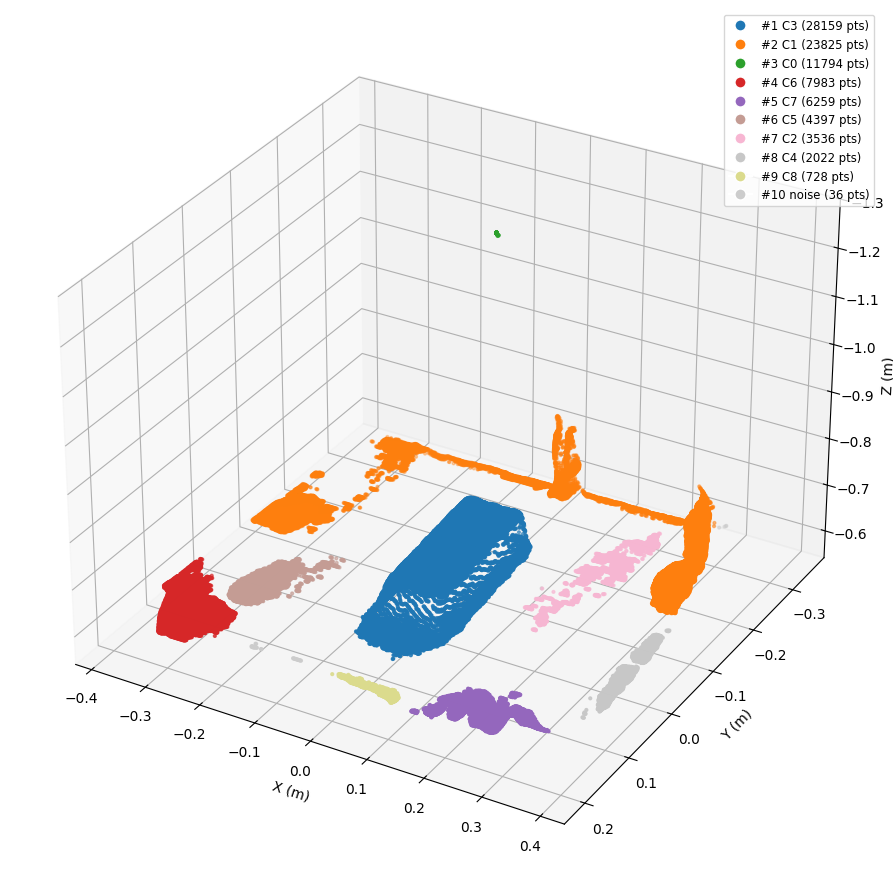

In [61]:
# Matplotlib 3D Plot
from matplotlib.lines import Line2D

points = np.asarray(obj_pc.points)
colors = np.array([label_color_map[lab] for lab in labels])

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], c=colors, s=4)

# invert axes to match original orientation
ax.invert_yaxis()
ax.invert_zaxis()

# build legend in ranked order
handles = []
for rank, lab in enumerate(clusters, start=1):
    handles.append(
        Line2D([0],[0], marker='o', color='w',
               markerfacecolor=label_color_map[lab],
               markersize=8,
               label=f"#{rank} C{lab} ({sizes[rank-1]} pts)")
    )
if noise_count:
    handles.append(
        Line2D([0],[0], marker='o', color='w',
               markerfacecolor=label_color_map[-1],
               markersize=8,
               label=f"#{n+1} noise ({noise_count} pts)")
    )

ax.legend(handles=handles, loc='best', fontsize='small')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
plt.tight_layout()
plt.show()



### Fit the Lid Plane of the Box

In [62]:
# RANSAC to find dominant plane, this will be top of box
n_lid, d_lid, lid_inliers = plane_fit(box_pc)
lid_pc = box_pc.select_by_index(lid_inliers)

print(f"Plane: {n_lid} * x + {d_lid:.2f} = 0")

Plane: [-0.05402683 -0.03344554  0.99797921] * x + 0.69 = 0


In [42]:
lid_pc.paint_uniform_color([0.0, 1.0, 0.0])
box_pc.paint_uniform_color([0.5, 0.5, 0.5])
o3d.visualization.draw_geometries([lid_pc, box_pc], window_name="Lid (Green) on Box")

### Measure Dimensions (L, W, H)

In [63]:
import open3d as o3d
import numpy as np
from scipy.spatial import ConvexHull

def compute_2d_obb_from_lid(lid_pc: o3d.geometry.PointCloud):
    # Step 1: Get XY coordinates of lid points (project to 2D)
    points = np.asarray(lid_pc.points)
    xy = points[:, :2]  # Ignore Z

    # Step 2: Compute convex hull
    hull = ConvexHull(xy)
    hull_pts = xy[hull.vertices]

    # Step 3: Rotating calipers: test all edges of the hull
    min_area = float("inf")
    best_rect = None

    for i in range(len(hull_pts)):
        # Edge vector
        edge = hull_pts[(i + 1) % len(hull_pts)] - hull_pts[i]
        edge /= np.linalg.norm(edge)  # normalize

        # Get orthogonal vector (rotate 90°)
        ortho = np.array([-edge[1], edge[0]])

        # Build rotation matrix to align edge with X-axis
        R = np.stack([edge, ortho]).T

        # Rotate all hull points
        rot_pts = hull_pts @ R

        # Get bounding box in this frame
        min_xy = rot_pts.min(axis=0)
        max_xy = rot_pts.max(axis=0)
        extent = max_xy - min_xy
        area = extent[0] * extent[1]

        # Update if this is the smallest area
        if area < min_area:
            min_area = area
            best_rect = (R, min_xy, max_xy)

    # Step 4: Recover the best rectangle in world coords
    R, min_xy, max_xy = best_rect
    center_2d = (min_xy + max_xy) / 2
    corners_2d = np.array([
        [min_xy[0], min_xy[1]],
        [max_xy[0], min_xy[1]],
        [max_xy[0], max_xy[1]],
        [min_xy[0], max_xy[1]],
    ])
    world_corners = (corners_2d @ R.T)

    # Estimate average Z height of lid for 3D placement
    z_mean = np.mean(points[:, 2])
    corners_3d = np.column_stack([world_corners, np.full(4, z_mean)])

    # Return rectangle corners and length/width
    length, width = np.abs(max_xy - min_xy)
    return corners_3d, length, width


In [64]:
corners, length, width = compute_2d_obb_from_lid(lid_pc)
print(f"Lid dimensions ≈ {length * 100:.2f} × {width * 100:.2f} cm")

# Optional: create and visualize a line set for the box
lines = [[0,1],[1,2],[2,3],[3,0]]
colors = [[1, 0.5, 0] for _ in lines]  # orange

line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(corners),
    lines=o3d.utility.Vector2iVector(lines),
)
line_set.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([lid_pc, line_set])

Lid dimensions ≈ 20.32 × 9.88 cm


In [65]:
# Old code using bounding box
# XY from lid's oriented bounding box
lid_obb = lid_pc.get_oriented_bounding_box()
xy_m = lid_obb.extent[:2]

In [66]:
# Height from plane offset difference
height_m = abs(d_lid - d_tab)

# Final dimensions in cm
dims_cm = np.array([length, width, height_m]) * 100.0
print(f"Box ≈ {dims_cm[0]:.2f} × {dims_cm[1]:.2f} × {dims_cm[2]:.2f} cm  (L×W×H)")

Box ≈ 20.32 × 9.88 × 7.83 cm  (L×W×H)


In [69]:
print(d_lid * 100.0)

69.33281185223692


### Visualize Final Result

In [41]:
# Create table bounding boxes
table_obj = table_pc.get_oriented_bounding_box()

# Set colors
table_obj.color = (1.0, 0.0, 0.0)
table_pc.paint_uniform_color([1.0, 0.0, 0.0]) # table = red
lid_pc.paint_uniform_color([0.0, 1.0, 0.0]) # lid = green
box_pc.paint_uniform_color([0.2, 0.8, 1.0]) # box body = cyan

o3d.visualization.draw_geometries(
    [table_pc, lid_pc, box_pc, line_set, table_obj],
    window_name="Final Visualization: Table, Lid, Box, OBB",
    width=800, height=600
)

### 3D box visualization

In [15]:
def visualize_measured_box(length: float,
                           width: float,
                           height: float,
                           color=(0.8, 0.2, 0.2)):
    """
    Create and display a box mesh of the given dimensions.
    
    Parameters:
      - length: extent along X (meters)
      - width:  extent along Y (meters)
      - height: extent along Z (meters)
      - color:  RGB tuple for the box color
    """
    # 1) Create a unit box mesh at the origin, extents along +X, +Y, +Z
    box = o3d.geometry.TriangleMesh.create_box(width=length,
                                               height=width,
                                               depth=height)
    box.compute_vertex_normals()
    
    # 2) Re‐center so it sits on the Z=0 plane and is centered in X/Y
    box.translate((-length / 2, -width / 2, 0.0))
    
    # 3) Color it
    box.paint_uniform_color(color)
    
    # 4) Show it
    o3d.visualization.draw_geometries([box],
                                      window_name="Measured Box",
                                      width=600, height=400)

# Example: if your dims_cm were [L_cm, W_cm, H_cm] in centimeters,
# convert to meters:
L, W, H = dims_cm / 100.0

visualize_measured_box(L, W, H, color=(1.0, 0.5, 0.0))  # orange


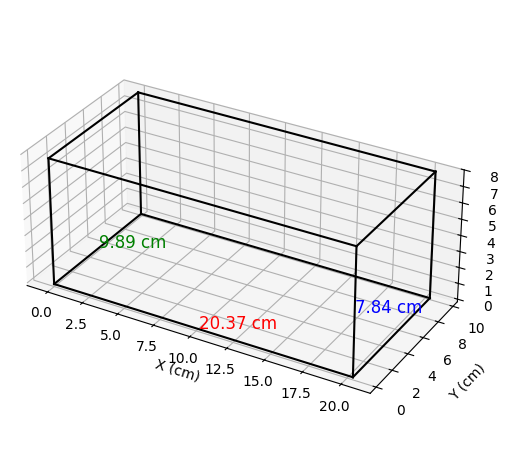

In [17]:
import matplotlib.pyplot as plt

def plot_box_with_three_labels_right_corner(length, width, height, units='cm'):
    """
    Plot a 3D wireframe box and annotate only length, width, and height.
    The height label is positioned at the front-right vertical edge.
    """
    # Define the 8 corners of the box
    corners = [
        (0, 0, 0),
        (length, 0, 0),
        (length, width, 0),
        (0, width, 0),
        (0, 0, height),
        (length, 0, height),
        (length, width, height),
        (0, width, height),
    ]

    # Define edges as pairs of corner indices
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),  # bottom
        (4, 5), (5, 6), (6, 7), (7, 4),  # top
        (0, 4), (1, 5), (2, 6), (3, 7)   # verticals
    ]

    # Create figure and 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot all edges
    for start, end in edges:
        xs = [corners[start][0], corners[end][0]]
        ys = [corners[start][1], corners[end][1]]
        zs = [corners[start][2], corners[end][2]]
        ax.plot(xs, ys, zs, color='k')

    # Annotate only three edges:
    # Length: midpoint of edge 0-1 (along X)
    ax.text(length/2, 0, 0, f"{length:.2f} {units}", size=12, color='r')

    # Width: midpoint of edge 0-3 (along Y)
    ax.text(0, width/2, 0, f"{width:.2f} {units}", size=12, color='g')

    # Height: midpoint of front-right vertical edge (1-5)
    ax.text(length, 0, height/2, f"{height:.2f} {units}", size=12, color='b')

    # Label axes
    ax.set_xlabel(f'X ({units})')
    ax.set_ylabel(f'Y ({units})')
    ax.set_zlabel(f'Z ({units})')

    # Equal aspect ratio
    ax.set_box_aspect((length, width, height))

    plt.tight_layout()
    plt.show()

# Example usage with measured dims in cm (replace with your dims_cm):
L, W, H = dims_cm
plot_box_with_three_labels_right_corner(L, W, H, units='cm')

